In [68]:

!pip install plotly_express

In [69]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics.pairwise import cosine_similarity
import re
from nltk.corpus import stopwords
import nltk
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.sparse.linalg import svds
import plotly_express as px
import random
import matplotlib.pyplot as plt

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [70]:
# Load English stopwords
stop_words = set(stopwords.words('english'))

# Load data
reviews_df = pd.read_csv("/content/final_reviews.csv")
users_df = pd.read_csv("/content/users_final.csv")
businesses_df = pd.read_csv("/content/business_final.csv")
final_reviews = pd.read_csv("/content/final_reviews.csv")
final_reviews.drop(['Unnamed: 0'], axis=1, inplace = True)
print(final_reviews.shape)
final_reviews.head(3)

(180818, 25)


,business_id,user_id,stars,useful,funny,cool,text,date,year,month,...,cleaned_text,polarity,subjectivity,neg,neu,pos,compound,Dominant_Topic,Keywords,Text_Chunks
0,YjUWPpI6HXG530lwP-fb2A,8g_iMtfSiwikVnbP2etR0A,3.0,0.0,0.0,0.0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30,2014.0,2.0,...,family diner buffet eclectic assortment large ...,0.139935,0.522294,0.033,0.722,0.245,0.9201,1.0,"food, place, great, service, love, well, alway...","['family', 'eclectic', 'assortment', 'large', ..."
1,5Ce3lZksYVkCbrihqylVHQ,yZdAhQ_KmKuCZmbBy9YDQg,5.0,0.0,0.0,0.0,I just started going to Sushi Nara this month ...,2014-07-25 17:56:26,2014.0,7.0,...,started going sushi nara month opened short ti...,0.376515,0.677273,0.017,0.768,0.215,0.9735,1.0,"food, place, great, service, love, well, alway...","['start', 'month', 'open', 'short', 'time', 'a..."
2,7L1kXfwU5XM6f6Jxo_L7Yg,hToW2eoTAYlOcuNz7I73Cg,5.0,1.0,0.0,0.0,We've been coming here since I was a kid. The ...,2015-07-03 22:36:04,2015.0,7.0,...,weve coming since kid staff watched kid grow t...,0.444444,0.612963,0.000,0.738,0.262,0.9661,1.0,"food, place, great, service, love, well, alway...","['kid', 'staff', 'watch', 'kid', 'grow', 'pers..."


## Creating a Super-Score Rating

The first step to building our recommendation systems is to develop a rating score that reflects each user's overall preference for a restaurant. In our reviews dataset, we have the actual rating(stars) that users have indicated in their Yelp Reviews. However, we will try and build our **own Super Score rating** by combining these ratings with other sentiment scores like Textblob's `polarity` and VADER `compound` scores.

- The **polarity** of a text ranges from -1 to +1, negative to positive.
- The **subjectivity** score ranges from 0 to 1, very objective to very subjective.
- The **compound** score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive).

Formula: **Super Score** = ``stars + (polarity x compound)``

In [71]:
# Computing Super-Score Rating for Reviews

final_reviews['super_score'] = final_reviews['polarity'] *  final_reviews['compound']
final_reviews['super_score'] = final_reviews['super_score'] + final_reviews['stars']
final_reviews.sample(3)

,business_id,user_id,stars,useful,funny,cool,text,date,year,month,...,polarity,subjectivity,neg,neu,pos,compound,Dominant_Topic,Keywords,Text_Chunks,super_score
170259,fgtnOag-DaTsZTHPsgnWSQ,txIBy8cwHNZVg78tW7x4Cg,5.0,0.0,1.0,0.0,"Great food, fast and friendly service! Wide se...",2019-06-05 19:50:41,2019.0,6.0,...,0.2125,0.458333,0.000,0.510,0.490,0.8906,1.0,"food, place, great, service, love, well, alway...","['place', 'cool', 'chill', 'day', 'drink', 'sp...",5.189253
99404,T4E23iml3us2oH_OVGBr4Q,dLOAGmsL2lCTw3Xs8HLXvw,5.0,1.0,1.0,1.0,We always enjoy our meals here - either at the...,2016-04-21 20:02:43,2016.0,4.0,...,0.7000,0.700000,0.051,0.779,0.170,0.8165,3.0,"order, sauce, fry, burger, chicken, taste, fla...","['bad', 'ever', 'taste', 'poorly', 'season', '...",5.571550
32112,YQT53_5tc_sp3_Xp4c5Ehw,R-rJLUjluaLZlcWwcWmlpw,2.0,0.0,0.0,0.0,I used to love going to this place great food ...,2021-10-25 00:38:24,2021.0,10.0,...,0.4000,0.362500,0.036,0.742,0.222,0.8821,1.0,"food, place, great, service, love, well, alway...","['amazing', 'usually', 'sausage', 'burrito', '...",2.352840


In [72]:
# Checking whether there are any rows with zero super scores

final_reviews[final_reviews['super_score']==0.0]

,business_id,user_id,stars,useful,funny,cool,text,date,year,month,...,polarity,subjectivity,neg,neu,pos,compound,Dominant_Topic,Keywords,Text_Chunks,super_score


In [73]:
# Minimum Super Score Rating

final_reviews['super_score'].min()

0.13590000000000002

In [74]:
# Maximum Super Score Rating

final_reviews['super_score'].max()

5.9780999999999995

The range of Super Score Ratings is from [0,6].

## Cold-Start Problem

Recommender systems have a problem known as **user cold-start**, in which it is hard to provide personalized recommendations for users with none or a very few number of consumed items, due to the lack of information to model their preferences.

For example, if I am new to a city or I am a new user of a food delivery app, it will be difficult to provide personal recommendations due to the lack of information about my own personal preferences with regards to food and restaurants.

With the cold-start problem, we have to give good recommendations to users that have provided no feedback. Essentially, their data is empty, and there are no relations that can be inferred for this user. The naive solution for this problem could be to first give a random recommendation, and for every following recommendation: **take feedback, retrain, sort the predicted ratings, and return the highest projected recommendation.**

One way where we can give a new user recommendations would be through **location proximity data.** Knowing a person's geographical location at the point of time where he is deciding to find new Restaurants to visit, we can use a **Location-Based Recommendation System** to recommend Restaurants near his/her vicinity. By providing an initial recommendation that is convenient for the user, we can attract him to start using our app and thereafter build on his initial preference to recommend other restaurants using our other alternative Recommendation Systems.

# Location-Based Recommendation System

In [75]:
# Reading in Restaurant Businesses Final CSV File

business_final = pd.read_csv('/content/business_final.csv')
business_final.drop(['Unnamed: 0'], axis=1, inplace = True)
print(business_final.shape)
business_final.head(3)

(1641, 12)


,business_id,name,city,state,stars,review_count,categories,latitude,longitude,is_open,postal_code,key
0,anLQj9AM8vjbcLSIE0iUgg,Papa Murphy's,Tucson,AZ,4.0,22,"Pizza, Restaurants",32.338572,-111.010760,1,85741.0,anLQj9AM8vjbcLSIE0iUgg
1,9C2rpb56aQvW0ViZHK9sPw,Home Plate Sports Pub,Tucson,AZ,3.5,56,"Bars, Restaurants, Sports Bars, Nightlife",32.206315,-110.887843,1,85711.0,9C2rpb56aQvW0ViZHK9sPw
2,Y6heWJJ9AmEL58fZwgi9YQ,Rosati's Pizza,Tucson,AZ,4.0,58,"Sports Bars, Bars, Nightlife, Italian, Restaur...",32.338724,-111.030310,1,85741.0,Y6heWJJ9AmEL58fZwgi9YQ


In [76]:
# Filtering for Selected Columns

business_final['business_id'] = business_final['business_id ']
business_final = business_final[['business_id', 'name', 'categories','stars','review_count','latitude','longitude','postal_code']]
business_final.head()

,business_id,name,categories,stars,review_count,latitude,longitude,postal_code
0,anLQj9AM8vjbcLSIE0iUgg,Papa Murphy's,"Pizza, Restaurants",4.0,22,32.338572,-111.010760,85741.0
1,9C2rpb56aQvW0ViZHK9sPw,Home Plate Sports Pub,"Bars, Restaurants, Sports Bars, Nightlife",3.5,56,32.206315,-110.887843,85711.0
2,Y6heWJJ9AmEL58fZwgi9YQ,Rosati's Pizza,"Sports Bars, Bars, Nightlife, Italian, Restaur...",4.0,58,32.338724,-111.030310,85741.0
3,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,"Restaurants, Salad, Pakistani, Indian, Cocktai...",4.0,446,32.250960,-110.959158,85719.0
4,D7z_V6E8cxXghSRcHAmUPg,La Bella China Restaurant,"Restaurants, Chinese",4.0,92,32.149473,-110.978186,85706.0


In [77]:
# Geographical Overview of Restaurants in Tuscon Area

px.set_mapbox_access_token("pk.eyJ1Ijoic2hha2Fzb20iLCJhIjoiY2plMWg1NGFpMXZ5NjJxbjhlM2ttN3AwbiJ9.RtGYHmreKiyBfHuElgYq_w")
fig = px.scatter_mapbox(business_final, lat="latitude", lon="longitude", color="stars", size='review_count',
                   size_max=15, zoom=10, width=1000, height=700)

fig.update_layout(mapbox_style="dark")
fig.show()

## K-Means Clustering

Based on the above visualization, we can see that there are areas in Tuscon where there is a high density of Restaurants while there are also other areas that have fewer Restaurants. Depending on where a user is currently located, it would make sense to recommend restaurants that are close to his location regardless of where he is in a city.

Hence, one way where we can group restaurants together based on geographical location is using the K-Means Clustering Algorithm. The **K-Means algorithm** predicts the cluster where the user is located in and pulls out this cluster’s top 10 restaurants and recommends them to him.

In [78]:
# Putting the Coordinates of Restaurants together into a dataframe

coordinates = business_final[['longitude','latitude']]
coordinates

,longitude,latitude
0,-111.010760,32.338572
1,-110.887843,32.206315
2,-111.030310,32.338724
3,-110.959158,32.250960
4,-110.978186,32.149473
...,...,...
1636,-110.960460,32.287556
1637,-110.803966,32.257496
1638,-110.830286,32.219594
1639,-111.112350,32.356266


In [79]:
# Elbow method to determine the number of K in Kmeans Clustering

distortions = []
K = range(1,15)
for k in K:
    kmeansModel = KMeans(n_clusters=k)
    kmeansModel = kmeansModel.fit(coordinates)
    distortions.append(kmeansModel.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

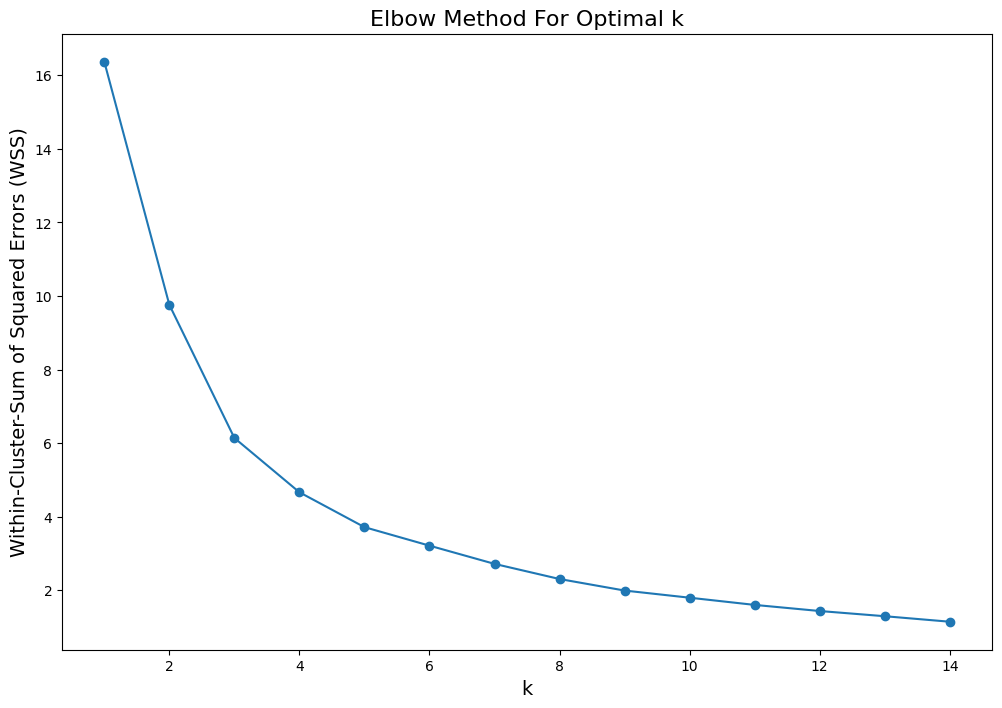

In [80]:
# Elbow Graph for WSS

fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(K, distortions, marker='o')
plt.xlabel('k', fontsize = 14)
plt.ylabel('Within-Cluster-Sum of Squared Errors (WSS)', fontsize = 14)
plt.title('Elbow Method For Optimal k', fontsize = 16)
plt.show()

For the **Elbow Method**, we calculate the **Within-Cluster-Sum of Squared Errors (WSS)** for different values of k, and choose the k for which WSS first starts to diminish. In the plot of WSS-versus-k, this is visible as an elbow. Based on the above figure, the optimal **k = 4 (clusters).**

In [81]:
# Silhouette Score Method to to determine the number of K in Kmeans Clustering

sil = []
kmax = 25

# Dissimilarity would not be defined for a single cluster. Minimum number of clusters should be 2

for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(coordinates)
  labels = kmeans.labels_
  sil.append(silhouette_score(coordinates, labels, metric = 'euclidean'))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

In [82]:
# Silhouette Scores

sil

[0.3952856867325818,
 0.43047296007428115,
 0.42825555341220994,
 0.4513646808465284,
 0.43432563411651626,
 0.43774356382630514,
 0.41376393968047737,
 0.42493346293242434,
 0.4371949827024641,
 0.4404990416253192,
 0.42729992487085033,
 0.4267858100602735,
 0.4406806540688997,
 0.4176711649419445,
 0.420437567967437,
 0.42062850524897255,
 0.4358774584823307,
 0.4355318642375904,
 0.44147548160577355,
 0.416492939726262,
 0.45170931754964516,
 0.43611759362805796,
 0.4336911702301122,
 0.45156900244386894]

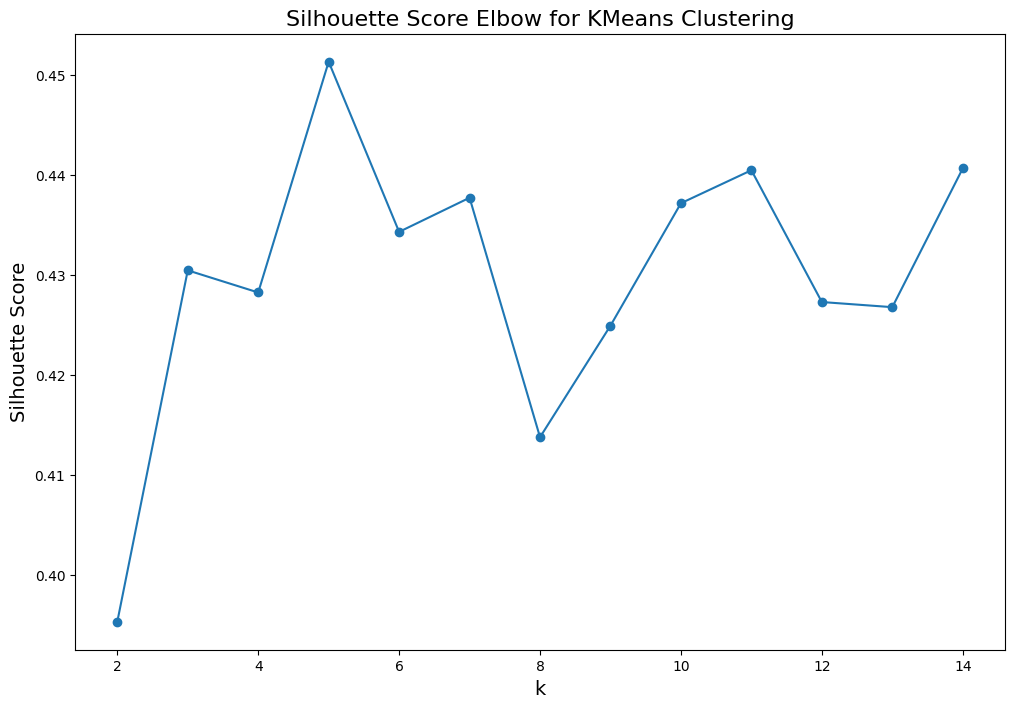

In [83]:
# Elbow Graph for Silhouette Score

fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(K[1:15], sil[:13], marker='o')
plt.xlabel('k', fontsize = 14)
plt.ylabel('Silhouette Score', fontsize = 14)
plt.title('Silhouette Score Elbow for KMeans Clustering', fontsize = 16)
plt.show()

The **Silhouette Score** measures how similar a point is to its own cluster (cohesion) compared to other clusters (separation). The range of the Silhouette value is between +1 and -1. A high value is desirable and indicates that the point is placed in the correct cluster. The Silhouette Score reaches its **global maximum** at the **optimal k.**
 Starting from 2 clusters, the optimal k based on the above Silhouette Scores would be **k = 4 (clusters).**

In [116]:
# Setting K = 4

kmeans = KMeans(n_clusters = 4, init = 'k-means++')
kmeans.fit(coordinates)
y = kmeans.labels_
print("k = 4", " silhouette_score ", silhouette_score(coordinates, y, metric='euclidean'))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



k = 4  silhouette_score  0.42913055134236155


In [85]:
business_final['init_cluster'] = kmeans.predict(business_final[['longitude','latitude']])
business_final.head()

,business_id,name,categories,stars,review_count,latitude,longitude,postal_code,init_cluster
0,anLQj9AM8vjbcLSIE0iUgg,Papa Murphy's,"Pizza, Restaurants",4.0,22,32.338572,-111.010760,85741.0,0
1,9C2rpb56aQvW0ViZHK9sPw,Home Plate Sports Pub,"Bars, Restaurants, Sports Bars, Nightlife",3.5,56,32.206315,-110.887843,85711.0,2
2,Y6heWJJ9AmEL58fZwgi9YQ,Rosati's Pizza,"Sports Bars, Bars, Nightlife, Italian, Restaur...",4.0,58,32.338724,-111.030310,85741.0,0
3,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,"Restaurants, Salad, Pakistani, Indian, Cocktai...",4.0,446,32.250960,-110.959158,85719.0,3
4,D7z_V6E8cxXghSRcHAmUPg,La Bella China Restaurant,"Restaurants, Chinese",4.0,92,32.149473,-110.978186,85706.0,1


In [86]:
# Geographical Plot of 4 Clusters

px.set_mapbox_access_token("pk.eyJ1Ijoic2hha2Fzb20iLCJhIjoiY2plMWg1NGFpMXZ5NjJxbjhlM2ttN3AwbiJ9.RtGYHmreKiyBfHuElgYq_w")
fig = px.scatter_mapbox(business_final, lat="latitude", lon="longitude", color="init_cluster", size='review_count',
                  hover_data= ['name', 'latitude', 'longitude'], zoom=10, width=1000, height=700)

fig.update_layout(mapbox_style="dark")
fig.show()

Based on the above plot, we see that even though there are 4 clusters, the less dense regions have restaurants within clusters that are spread out across long distances. Hence, this might dissuade users from visiting the restaurants that we have recommended if they are too far from his location.

While 4 clusters might seem optimal, in this case, it would be better to have more clusters that are smaller and more spread out across the city of Tuscon.

In [87]:
# Let's try k = 10

kmeans = KMeans(n_clusters = 10, init = 'k-means++')
kmeans.fit(coordinates)
y = kmeans.labels_
print("k = 10", " silhouette_score ", silhouette_score(coordinates, y, metric='euclidean'))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



k = 10  silhouette_score  0.42045713034443305


In [88]:
business_final['cluster'] = kmeans.predict(business_final[['longitude','latitude']])
business_final.head()

,business_id,name,categories,stars,review_count,latitude,longitude,postal_code,init_cluster,cluster
0,anLQj9AM8vjbcLSIE0iUgg,Papa Murphy's,"Pizza, Restaurants",4.0,22,32.338572,-111.010760,85741.0,0,6
1,9C2rpb56aQvW0ViZHK9sPw,Home Plate Sports Pub,"Bars, Restaurants, Sports Bars, Nightlife",3.5,56,32.206315,-110.887843,85711.0,2,5
2,Y6heWJJ9AmEL58fZwgi9YQ,Rosati's Pizza,"Sports Bars, Bars, Nightlife, Italian, Restaur...",4.0,58,32.338724,-111.030310,85741.0,0,2
3,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,"Restaurants, Salad, Pakistani, Indian, Cocktai...",4.0,446,32.250960,-110.959158,85719.0,3,0
4,D7z_V6E8cxXghSRcHAmUPg,La Bella China Restaurant,"Restaurants, Chinese",4.0,92,32.149473,-110.978186,85706.0,1,9


In [89]:
# Geographical Plot of 10 Clusters

px.set_mapbox_access_token("pk.eyJ1Ijoic2hha2Fzb20iLCJhIjoiY2plMWg1NGFpMXZ5NjJxbjhlM2ttN3AwbiJ9.RtGYHmreKiyBfHuElgYq_w")
fig = px.scatter_mapbox(business_final, lat="latitude", lon="longitude", color="cluster", size='review_count',
                  hover_data= ['name', 'latitude', 'longitude'], zoom=10, width=1000, height=800)

fig.update_layout(mapbox_style="dark")
fig.show()

Tucson's total land area is **587.2 km²**, as such having more clusters would allow our Location-Based Recommendation System to recommend users restaurants that are at a closer proximity to their own geographical location.

Apart from recommending restaurants that are close to a user, it is also important that the recommended restaurannts have a **rating that is as high as possible.** Restaurants that have an overall higher rating (star) generally translates to **better customer experience** which will improve user's customer satisfaction of using our recommendationn system.

In [90]:
# Sort Restaurants based on Stars(rating) and subsequently by Review_count

top_restaurants_tucson = business_final.sort_values(by=['stars', 'review_count'], ascending=False)
top_restaurants_tucson.head()

,business_id,name,categories,stars,review_count,latitude,longitude,postal_code,init_cluster,cluster
171,DVBJRvnCpkqaYl6nHroaMg,Tumerico,"Mexican, Gluten-Free, Vegetarian, Restaurants,...",5.0,705,32.227705,-110.934722,85716.0,3,0
325,6OwxdpajDSJi3DkMqkr2sw,Barista Del Barrio,"Restaurants, Food, Breakfast & Brunch, Coffee ...",5.0,357,32.234870,-110.989976,85745.0,3,0
1506,jh8j-DWqgWkbRe_a2XtKFQ,Barrio Bread,"Food, Specialty Food, Bakeries, Restaurants",5.0,221,32.220885,-110.927943,85716.0,3,0
743,elP0Xn9HyP6cRBuzbJdTpw,Urban Fresh,"Vegan, Live/Raw Food, Food, Juice Bars & Smoot...",5.0,191,32.223080,-110.970170,85701.0,3,0
1286,NbTNxhZXhPOPUhBFXZ1jLQ,The Blacktop Grill,"Hot Dogs, Food Stands, Nightlife, Mexican, Foo...",5.0,99,32.357595,-111.046310,85741.0,0,2


In [91]:
def location_based_recommendation(df, latitude, longitude, kmeans_model):
    """Predict the cluster for longitude and latitude provided"""
    cluster = kmeans_model.predict(np.array([longitude, latitude]).reshape(1, -1))[0]
    result_string = f"This restaurant belongs to cluster: {cluster}"

    # Set feature names to cluster_centers_
    kmeans_model.cluster_centers_ = np.array([[longitude, latitude]])

    """Get the best restaurant in this cluster along with the relevant information for a user to make a decision"""
    result_df = df[df['cluster'] == cluster].iloc[0:10][['name', 'latitude', 'longitude', 'categories', 'stars', 'review_count', 'cluster']]

    return result_string, result_df

In [92]:
reviews_df = pd.read_csv('/content/final_reviews.csv')
users_df = pd.read_csv("/content/users_final.csv")
businesses_df = pd.read_csv("/content/business_final.csv")

In [93]:
# reviews_df.shape
print(reviews_df.columns)
reviews_df.head()

Index(['Unnamed: 0', 'business_id', 'user_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date', 'year', 'month', 'time', 'word_count',
       'char_count', 'avg_word_len', 'stopword_count', 'cleaned_text',
       'polarity', 'subjectivity', 'neg', 'neu', 'pos', 'compound',
       'Dominant_Topic', 'Keywords', 'Text_Chunks'],
      dtype='object')


,Unnamed: 0,business_id,user_id,stars,useful,funny,cool,text,date,year,...,cleaned_text,polarity,subjectivity,neg,neu,pos,compound,Dominant_Topic,Keywords,Text_Chunks
0,0,YjUWPpI6HXG530lwP-fb2A,8g_iMtfSiwikVnbP2etR0A,3.0,0.0,0.0,0.0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30,2014.0,...,family diner buffet eclectic assortment large ...,0.139935,0.522294,0.033,0.722,0.245,0.9201,1.0,"food, place, great, service, love, well, alway...","['family', 'eclectic', 'assortment', 'large', ..."
1,1,5Ce3lZksYVkCbrihqylVHQ,yZdAhQ_KmKuCZmbBy9YDQg,5.0,0.0,0.0,0.0,I just started going to Sushi Nara this month ...,2014-07-25 17:56:26,2014.0,...,started going sushi nara month opened short ti...,0.376515,0.677273,0.017,0.768,0.215,0.9735,1.0,"food, place, great, service, love, well, alway...","['start', 'month', 'open', 'short', 'time', 'a..."
2,2,7L1kXfwU5XM6f6Jxo_L7Yg,hToW2eoTAYlOcuNz7I73Cg,5.0,1.0,0.0,0.0,We've been coming here since I was a kid. The ...,2015-07-03 22:36:04,2015.0,...,weve coming since kid staff watched kid grow t...,0.444444,0.612963,0.000,0.738,0.262,0.9661,1.0,"food, place, great, service, love, well, alway...","['kid', 'staff', 'watch', 'kid', 'grow', 'pers..."
3,3,WLiqfxv_GhFFA5sm878a2w,CysTz612pTix75Fye6-D4Q,5.0,0.0,1.0,1.0,Blew $80 on food for the family was worth it f...,2013-12-29 03:15:34,2013.0,...,blew 80 food family worth food hot orange chic...,0.190000,0.440000,0.000,0.813,0.187,0.7707,1.0,"food, place, great, service, love, well, alway...","['blow', 'food', 'family', 'worth', 'food', 'h..."
4,4,3YERGr7UbpSpddqL0Eiu5g,7zJVt_Bl1h5hLjhxl2c1PQ,5.0,1.0,0.0,1.0,This is my favorite restaurant! I always orde...,2017-12-16 00:18:10,2017.0,...,favorite restaurant always order ceviche delic...,0.539286,0.692857,0.000,0.572,0.428,0.9647,1.0,"food, place, great, service, love, well, alway...","['favorite', 'restaurant', 'always', 'order', ..."


In [94]:
users_df.shape
users_df.columns

Index(['Unnamed: 0', 'user_id', 'user_name', 'user_review_count',
       'user_yelp_since', 'friends', 'useful_reviews', 'funny_reviews',
       'cool_reviews', 'n_fans', 'average_stars'],
      dtype='object')

In [95]:
businesses_df.shape
businesses_df.columns
businesses_df.rename(columns={'business_id ': 'business_id'}, inplace=True)
businesses_df

,Unnamed: 0,business_id,name,city,state,stars,review_count,categories,latitude,longitude,is_open,postal_code,key
0,126,anLQj9AM8vjbcLSIE0iUgg,Papa Murphy's,Tucson,AZ,4.0,22,"Pizza, Restaurants",32.338572,-111.010760,1,85741.0,anLQj9AM8vjbcLSIE0iUgg
1,132,9C2rpb56aQvW0ViZHK9sPw,Home Plate Sports Pub,Tucson,AZ,3.5,56,"Bars, Restaurants, Sports Bars, Nightlife",32.206315,-110.887843,1,85711.0,9C2rpb56aQvW0ViZHK9sPw
2,234,Y6heWJJ9AmEL58fZwgi9YQ,Rosati's Pizza,Tucson,AZ,4.0,58,"Sports Bars, Bars, Nightlife, Italian, Restaur...",32.338724,-111.030310,1,85741.0,Y6heWJJ9AmEL58fZwgi9YQ
3,319,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,Tucson,AZ,4.0,446,"Restaurants, Salad, Pakistani, Indian, Cocktai...",32.250960,-110.959158,1,85719.0,f82dhKNiUXsDVPMLqKYiIQ
4,457,D7z_V6E8cxXghSRcHAmUPg,La Bella China Restaurant,Tucson,AZ,4.0,92,"Restaurants, Chinese",32.149473,-110.978186,1,85706.0,D7z_V6E8cxXghSRcHAmUPg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1636,150000,aGOXuqO6yhN66tLYI61Thg,Jack in the Box,Tucson,AZ,4.5,13,"Tacos, American (Traditional), Fast Food, Mexi...",32.287556,-110.960460,1,85719.0,aGOXuqO6yhN66tLYI61Thg
1637,150034,DaBATIXMTo3kqt00rCc9Tg,Risky Business,Tucson,AZ,3.0,84,"Sports Bars, Bars, American (Traditional), Res...",32.257496,-110.803966,1,85749.0,DaBATIXMTo3kqt00rCc9Tg
1638,150055,afUES0Ul1NYPzQa7PdT2Yw,Alloro D.O.C.,Tucson,AZ,4.0,25,"Steakhouses, Breakfast & Brunch, Italian, Rest...",32.219594,-110.830286,1,85710.0,afUES0Ul1NYPzQa7PdT2Yw
1639,150182,ldT9ihVk6BG6fXWd1N3ybA,The Station Pub & Grill,Tucson,AZ,3.0,90,"Restaurants, American (Traditional)",32.356266,-111.112350,1,85743.0,ldT9ihVk6BG6fXWd1N3ybA


In [96]:
print("Columns in reviews_df:", reviews_df.columns)
print("Columns in businesses_df:", businesses_df.columns)

Columns in reviews_df: Index(['Unnamed: 0', 'business_id', 'user_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date', 'year', 'month', 'time', 'word_count',
       'char_count', 'avg_word_len', 'stopword_count', 'cleaned_text',
       'polarity', 'subjectivity', 'neg', 'neu', 'pos', 'compound',
       'Dominant_Topic', 'Keywords', 'Text_Chunks'],
      dtype='object')
Columns in businesses_df: Index(['Unnamed: 0', 'business_id', 'name', 'city', 'state', 'stars',
       'review_count', 'categories', 'latitude', 'longitude', 'is_open',
       'postal_code', 'key'],
      dtype='object')


In [97]:
# Load English stopwords
stop_words = set(stopwords.words('english'))

# Step 1: Extract business_id and text
new_df = reviews_df[['business_id', 'text']].copy()

# Step 2: Remove numbers, special characters, links, dollar values, and stopwords
def preprocess_text(text):
    # Remove links
    text = re.sub(r'http\S+', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove special characters except for letters and spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove dollar values
    text = re.sub(r'\$\d+(\.\d{1,2})?', '', text)
    # Convert text to lowercase and remove stopwords
    text = ' '.join([word.lower() for word in text.split() if word.lower() not in stop_words])
    return text

new_df['text'] = new_df['text'].apply(preprocess_text)

# Step 3: Normalize text
new_df['text'] = new_df['text'].apply(lambda x: x.lower())

# Step 4: Group by business_id and concatenate text
new_df = new_df.groupby('business_id')['text'].apply(lambda x: ', '.join(x)).reset_index()

# Step 5: Merge with businesses_df on business_id
merged_df = pd.merge(new_df, businesses_df, on='business_id')

# Step 6: Create a new column by concatenating text and categories
merged_df['text_category'] = merged_df['text'] + ', ' + merged_df['categories']

# Display the resulting dataframe
merged_df['city']

0       Tucson
1       Tucson
2       Tucson
3       Tucson
4       Tucson
         ...  
1634    Tucson
1635    Tucson
1636    Tucson
1637    Tucson
1638    Tucson
Name: city, Length: 1639, dtype: object

In [98]:
merged_df.columns
merged_df[merged_df['stars']==4.5]['stars'].value_counts()

4.5    246
Name: stars, dtype: int64

In [99]:
# # Rename columns and normalize text
# merged_df.rename(columns={'stars_x': 'stars'}, inplace=True)
# merged_df['normalized_text'] = merged_df['text'].apply(lambda x: x.lower())\
# Rename columns
merged_df.rename(columns={'stars_x': 'stars'}, inplace=True)

# Calculate average star rating grouped by restaurant name
merged_df['stars'] = merged_df.groupby('name')['stars'].transform('mean')

# Round off stars to the nearest integer
merged_df['stars'] = merged_df['stars'].round()

# Drop duplicates keeping the first occurrence
merged_df = merged_df.drop_duplicates(subset=['name'])

# Reset index
merged_df = merged_df.reset_index(drop=True)

# Print first few rows to verify changes
merged_df.columns

Index(['business_id', 'text', 'Unnamed: 0', 'name', 'city', 'state', 'stars',
       'review_count', 'categories', 'latitude', 'longitude', 'is_open',
       'postal_code', 'key', 'text_category'],
      dtype='object')

In [100]:
# Merge text and category columns and profile
# merged_df['text_category'] = merged_df['normalized_text'] + ',' + merged_df['categories']
text_category_profile = merged_df['categories'].apply(lambda x: len(x.split()))

In [101]:
stop_words = ['english']  # Define your stop words list
# merged_df['normalized_text'] = merged_df['normalized_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
merged_df['text_category'] = merged_df['categories'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

In [102]:
merged_df['text_category'][0]

'Nightlife, Burgers, Sports Bars, Bars, Restaurants, Dive Bars, Soup'

In [103]:
from sklearn.model_selection import train_test_split
# Train test split
# X_train_text, X_test_text, y_train, y_test = train_test_split(merged_df['normalized_text'], merged_df['stars'], test_size=0.2, random_state=42)
X_train_text_category, X_test_text_category, y_train, y_test = train_test_split(merged_df['text_category'], merged_df['stars'], test_size=0.2, random_state=42)

# Train TF-IDF Vectorizer
# vectorizer_text = TfidfVectorizer()
vectorizer_text_category = TfidfVectorizer()

# X_train_vectors_text = vectorizer_text.fit_transform(X_train_text)
X_train_vectors_text_category = vectorizer_text_category.fit_transform(X_train_text_category, y_train)

In [104]:
# Train Naive Bayes model
# nb_model_text = MultinomialNB()
# nb_model_text.fit(X_train_vectors_text, y_train)

nb_model_text_category = MultinomialNB()
nb_model_text_category.fit(X_train_vectors_text_category, y_train)

MultinomialNB()

In [105]:
# # Train Linear SVM model
# svm_model_text = LinearSVC(dual=False)
# svm_model_text.fit(X_train_vectors_text, y_train)

svm_model_text_category = LinearSVC(dual=False)
svm_model_text_category.fit(X_train_vectors_text_category, y_train)

LinearSVC(dual=False)

In [106]:
from sklearn.metrics import accuracy_score
# Evaluate accuracy of models
# X_test_vectors_text = vectorizer_text.transform(X_test_text)
X_test_vectors_text_category = vectorizer_text_category.transform(X_test_text_category)

# y_pred_text_nb = nb_model_text.predict(X_test_vectors_text)
y_pred_text_category_nb = nb_model_text_category.predict(X_test_vectors_text_category)

# y_pred_text_svm = svm_model_text.predict(X_test_vectors_text)
y_pred_text_category_svm = svm_model_text_category.predict(X_test_vectors_text_category)

# accuracy_text_nb = accuracy_score(y_test, y_pred_text_nb)
accuracy_text_category_nb = accuracy_score(y_test, y_pred_text_category_nb)

# accuracy_text_svm = accuracy_score(y_test, y_pred_text_svm)
accuracy_text_category_svm = accuracy_score(y_test, y_pred_text_category_svm)

# print("Accuracy of Naive Bayes model on text data:", accuracy_text_nb)
print("Accuracy of Naive Bayes model on text_category data:", accuracy_text_category_nb)

# print("Accuracy of Linear SVM model on text data:", accuracy_text_svm)
print("Accuracy of Linear SVM model on text_category data:", accuracy_text_category_svm)

Accuracy of Naive Bayes model on text_category data: 0.7339449541284404
Accuracy of Linear SVM model on text_category data: 0.7110091743119266


In [134]:
def restaurant_recommendation(text, vectorizer, model, merged_df, city):
    # Normalize the input text
    normalized_text = text.lower()
    # Transform text using pre-fitted vectorizer
    text_vector = vectorizer.transform([normalized_text])
    # Predict star rating
    predicted_stars = model.predict(text_vector)[0]
    # Get restaurants with the predicted star rating
    predicted_restaurants = merged_df[(merged_df['stars'] == predicted_stars) & (merged_df['city'] == city)][['name','stars','city']]

    if not predicted_restaurants.empty:
        # Randomly select a restaurant from the predicted restaurants
        random_index = random.randint(0, len(predicted_restaurants)-1)
        predicted_restaurant = predicted_restaurants.iloc[random_index]

        # Calculate cosine similarity between input text and all restaurant descriptions
        similarity_scores = cosine_similarity(text_vector, X_train_vectors_text_category)
        # Get top similar restaurants (excluding the predicted one)
        top_similar_indices = np.argsort(similarity_scores[0])[:-6:-1]  # Exclude the predicted restaurant itself
        recommended_restaurants = merged_df.iloc[top_similar_indices][(merged_df['city'] == city)][['name','stars','city']]

        return predicted_restaurant, recommended_restaurants

    else:
        print("No predicted restaurants.")
        return None, pd.DataFrame()  # Return None and an empty DataFrame


In [137]:
# Example input text
input_text = "Burger"
city = 'Tucson'
# Example usage
predicted_restaurant, recommended_restaurants = restaurant_recommendation(input_text, vectorizer_text_category, nb_model_text_category, merged_df, city)

# Print predicted restaurant and recommended restaurants
print("Predicted Restaurant:")
print(predicted_restaurant)

print("\nRecommended Restaurants:")
recommended_restaurants_sorted = recommended_restaurants.sort_values(by='stars', ascending=False)
print(recommended_restaurants_sorted)

Predicted Restaurant:
name     La Estrella Bakery
stars                   4.0
city                 Tucson
Name: 639, dtype: object

Recommended Restaurants:
                                              name  stars    city
295                                   La Chaiteria    5.0  Tucson
286                                  Monkey Burger    4.0  Tucson
297                                  Welcome Diner    4.0  Tucson
296                                  The Moonstone    4.0  Tucson
871  DoubleTree by Hilton Hotel Tucson - Reid Park    3.0  Tucson


In [111]:
users_df.head()

,Unnamed: 0,user_id,user_name,user_review_count,user_yelp_since,friends,useful_reviews,funny_reviews,cool_reviews,n_fans,average_stars
0,0,x7YtLnBW2dUnrrpwaofVQQ,Ronskee,37,2010-05-06 00:40:56,"EPBLDry-ObheloH-NuvbvQ, 0GHsxjCk-Ynzx4Ihj8tjPQ...",56,29,29,9,3.84
1,1,XLs_PhrJ7Qwn_RfgMM7Djw,Weili,90,2009-07-12 14:34:54,"gTX68_Us2eI2KjY21aOQ7g, e4nHt3ErihX7II-MHXVM1w...",71,21,19,1,3.62
2,2,QJI9OSEn6ujRCtrX06vs1w,J,1982,2007-03-19 18:15:32,"RyPeT_ICAtX8ah9dhDpEFw, W8r4aKPZFT3GPIQQDbqB6Q...",14004,6466,9879,316,3.61
3,3,KXZ8A8h7Q9ZJRU5TM9asjw,Joanne,102,2010-03-20 17:40:40,"2N4UPgpSHFYJ1OZ0WcvTEQ, JgZ1-9Ii2wCzHE2ylZb6qQ...",150,42,30,7,3.54
4,4,uVtkixXCP7LXRpC1EedGpA,Paulina,77,2011-03-08 03:00:03,"iPUviZxhOQoKkWjWdz4DUQ, N5dXuVZ2ofc1Oglk2NSVfA...",248,72,84,14,3.91


## Demo


In [129]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from IPython.display import display

# Assuming you have a dataframe 'users_df' with user information
# and another dataframe 'businesses_df' with business information including latitude and longitude

# Assuming you have a KMeans model 'kmeans_model' trained on your data

# Function to handle button click
def on_button_click(b):
    with output:
        clear_output(wait=True)

        # Get restaurant_name from dropdown widget
        selected_restaurant_name = restaurant_name_widget.value


        # Get restaurant's latitude and longitude using restaurant_name
        restaurant_info = businesses_df[businesses_df['name'] == selected_restaurant_name]

        if not restaurant_info.empty:
            restaurant_latitude = restaurant_info['latitude'].values[0]
            restaurant_longitude = restaurant_info['longitude'].values[0]

            # Call location_based_recommendation function with obtained restaurant coordinates
            result_string, result_df = location_based_recommendation(top_restaurants_tucson, restaurant_latitude, restaurant_longitude, kmeans)

            # Display the result string
            print(result_string)

            # Display the resulting dataframe
            display(result_df)
        else:
            print("Restaurant information not found.")

# Assuming 'businesses_df' has a 'business_name' column
restaurant_names = businesses_df['name'].tolist()
user_name = users_df['user_name'].tolist()
# Create dropdown widget for restaurant_name
user_name_widget = widgets.Dropdown(options=user_name, description='User Name:')
restaurant_name_widget = widgets.Dropdown(options=restaurant_names, description='Restaurant Name:')

# Create button widget
button = widgets.Button(description="Run Recommendations")

# Attach function to button click event
button.on_click(on_button_click)

# Arrange widgets and button
widgets_list = [user_name_widget,restaurant_name_widget, button]
input_widgets = widgets.VBox(widgets_list)
output = widgets.Output()

# Display the input widgets and button
display(input_widgets, output)


Output()

In [136]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Assuming you have a dataframe 'users_df' with user information
# and another dataframe 'businesses_df' with business information

# Function to handle button click
def on_button_click(b):
    with output:
        clear_output(wait=True)

        # Get selected user name from dropdown widget
        selected_user_name = user_name_widget.value

        # Assuming you have some way to get input text for the restaurant_recommendation function
        # For simplicity, I'll just use a text widget for the input text
        input_text = input_text_widget.value

        # Call restaurant_recommendation function with obtained user name and input text
        predicted_restaurant, recommended_restaurants = restaurant_recommendation(input_text, vectorizer_text_category, nb_model_text_category, merged_df, city)

        # Print predicted restaurant and recommended restaurants
        print("Predicted Restaurant:")
        print(predicted_restaurant)

        if not recommended_restaurants.empty:
            print("\nRecommended Restaurants:")
            recommended_restaurants_sorted = recommended_restaurants.sort_values(by='stars', ascending=False)
            print(recommended_restaurants_sorted)
        else:
            print("\nNo recommended restaurants.")

# Assuming 'users_df' has a 'user_name' column
user_names = users_df['user_name'].tolist()

# Create dropdown widget for user_name
user_name_widget = widgets.Dropdown(options=user_names, description='User Name:')
input_text_widget = widgets.Text(value='Soup', description='Input Text:')

# Create button widget
button = widgets.Button(description="Run Recommendations")

# Attach function to button click event
button.on_click(on_button_click)

# Arrange widgets and button
widgets_list = [user_name_widget, input_text_widget, button]
input_widgets = widgets.VBox(widgets_list)
output = widgets.Output()

# Display the input widgets and button
display(input_widgets, output)


Output()